## 读取数据
1.每条训练样本由95列构成，含义如下:  
\[0\]：样本id，无有效信息，可删除  
\[1,40\]：所在州的one-hot表示  
\[41,58\]：2d前的特征  
\[59,76\]：1d前的特征  
\[77,95\]：当天特征  
2.将样本重新组合成1d、2d、3d三种数据集，数据维度如下:  

day | train | pred
  - | - | -  
1    |(9886, 58)|(893, 57)|  
2    |(6293, 76)|(893, 75)|  
3    |(2700, 94)|(893, 93)|


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
np.random.seed(123)
tf.random.set_seed(123)

path = "../input/ml2021spring-hw1/"
train_file = path + "covid.train.csv"
test_file = path + "covid.test.csv"

def read_file(filename,mode,dayType):
    df = pd.read_csv(filename)
    cols = df.columns
    state_cols = list(cols[1:41])
    day1_cols = list(cols[41:59])
    day2_cols = list(cols[59:77])
    day3_cols = list(cols[77:])
    res = []
    if dayType == 1:
        train_cols = state_cols + day1_cols
        day1_df = df[state_cols+day1_cols]
        day2_df = df[state_cols+day2_cols]
        day3_df = df[state_cols+day3_cols]
        day1_df.columns = train_cols
        day2_df.columns = train_cols
        if("test" == mode):
            day3_df.columns = train_cols[:-1]
            train_df = pd.concat([day1_df,day2_df])
            res.append(train_df)
            res.append(day3_df)
        elif("train" == mode):
            day3_df.columns = train_cols
            train_df = pd.concat([day1_df,day2_df,day3_df])
            res.append(train_df)
    elif dayType == 2:
        train_cols = state_cols + day1_cols + day2_cols
        day1_df = df[state_cols+day1_cols+day2_cols]
        day2_df = df[state_cols+day2_cols+day3_cols]
        day1_df.columns = train_cols
        if("test" == mode):
            day2_df.columns = train_cols[:-1]
            res.append(day1_df)
            res.append(day2_df)
        elif("train" == mode):
            day2_df.columns = train_cols
            train_df = pd.concat([day1_df,day2_df])
            res.append(train_df)
    elif dayType == 3:
        train_cols = state_cols + day1_cols + day2_cols + day3_cols
        day1_df = df[train_cols]
        if("test" == mode):
#             select_cols = ['cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'tested_positive', 'cli.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'tested_positive.1', 'cli.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2']
#             day1_df = df[state_cols+select_cols]
            res.append(pd.DataFrame())
            res.append(day1_df)
        elif("train" == mode):
#             select_cols = ['cli', 'ili', 'hh_cmnty_cli', 'nohh_cmnty_cli', 'tested_positive', 'cli.1', 'hh_cmnty_cli.1', 'nohh_cmnty_cli.1', 'tested_positive.1', 'cli.2', 'hh_cmnty_cli.2', 'nohh_cmnty_cli.2','tested_positive.2']
#             day1_df = df[state_cols+select_cols]
            res.append(day1_df)
    return res

def read_train_test(train_file,test_file,dayType):
    train_res = read_file(train_file,"train",dayType)
    test_res = read_file(test_file,"test",dayType)
    train_df = pd.concat([train_res[0],test_res[0]])
    return train_df,test_res[1]

train_1d_df,test_1d_df = read_train_test(train_file,test_file,1)
train_2d_df,test_2d_df = read_train_test(train_file,test_file,2)
train_3d_df,test_3d_df = read_train_test(train_file,test_file,3)

## 特征工程  
特征归一化：将非one-hot特征缩放至0~1范围  
样本shuffle：原始数据中样本按州排序，需要将样本随机打散  
数据拆分：将数据集拆分为训练集和测试集，其中测试集占比10%  

day | train | test
  - | - | -  
1    |(8897, 57)|(989, 57)|  
2    |(5663, 75)|(630, 75)|  
3    |(2430, 93)|(270, 93)|

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
def scale_fea(sc,features,mode):
    state = features.values[:,:40]
    other_fea = features.values[:,40:]
    if('train' == mode):
        other_fea = features.values[:,40:]
        sc_other_fea = sc.fit_transform(other_fea)
    else:
        sc_other_fea = sc.transform(other_fea)
    res = np.hstack((state,sc_other_fea))
    return res

def gen_feature(train_df):
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    l_col = train_df.columns[-1]
    labels = train_df[l_col]
    features = train_df.drop(columns=[l_col])
    train_x,test_x,train_y,test_y = train_test_split(features,labels,test_size = 0.1)
    sc = StandardScaler()
    train_x = scale_fea(sc,train_x,'train')
    test_x = scale_fea(sc,test_x,'test')
    return train_x,train_y,test_x,test_y,sc

train_1d_x,train_1d_y,test_1d_x,test_1d_y,sc_1d = gen_feature(train_1d_df)
train_2d_x,train_2d_y,test_2d_x,test_2d_y,sc_2d = gen_feature(train_2d_df)
train_3d_x,train_3d_y,test_3d_x,test_3d_y,sc_3d = gen_feature(train_3d_df)

## 模型构造与训练  
使用dnn为三种数据集构建三个不同的模型,测试结果如下 

day | loss | rmse
  - | - | -  
1    |0.531236|0.728859|  
2    |0.497631|0.705429|  
3    |0.912615|0.955309|  

  
  


In [3]:
from keras.models import Sequential,load_model
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
def build_model(featureLen,dayType):
    if dayType == 1:
        network = Sequential()
        """
        network.add(Dense(128,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(64,activation='relu'))
        network.add(Dense(32,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0001)
        """
        network.add(Dense(128,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(64,activation='relu'))
        network.add(Dense(32,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0005)
        network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    elif dayType == 2:
        network = Sequential()
        """
        network.add(Dense(128,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(64,activation='relu'))
        network.add(Dense(32,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0001)
        """
        network.add(Dense(128,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(64,activation='relu'))
        network.add(Dense(32,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0005)
        network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    elif dayType == 3:
        network = Sequential()
        network.add(Dense(32,activation='relu',input_shape=(featureLen,)))
        network.add(Dense(16,activation='relu'))
        network.add(Dense(8,activation='relu'))
        network.add(Dense(4,activation='relu'))
        network.add(Dense(2,activation='relu'))
        network.add(Dense(1))
        opt = Adam(learning_rate = 0.0002)
        network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return network

def train_model(train_x,train_y,valid_size,featureLen,dayType,model_path,epoch,batch,patience,train_type='train'):
    network = build_model(featureLen,dayType)
    valid_x = train_x[:valid_size]
    partial_train_x = train_x[valid_size:]
    valid_y = train_y[:valid_size]
    partial_train_y = train_y[valid_size:]
    es = EarlyStopping(monitor='val_root_mean_squared_error',mode='min',verbose=1,patience=patience)
    ckpt = ModelCheckpoint(model_path,monitor='val_root_mean_squared_error',save_best_only=True,verbose=1,mode='min')
    if('train' == train_type):
        history = network.fit(partial_train_x,partial_train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es,ckpt]) #
    elif('total' == train_type):
        history = network.fit(train_x,train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es,ckpt])#,callbacks=[es]
    return network,history

def train_day_model(train_x,train_y,test_x,test_y,dayType,model_path,epoch,batch,patience,train_type='train'):
    valid_size = int(train_x.shape[0]/10)
    featureLen = train_x.shape[1]
    network,history = train_model(train_x,train_y,valid_size,featureLen,dayType,model_path,epoch,batch,patience,train_type)
    test_loss, test_rmse = network.evaluate(test_x, test_y)
    print('test_loss:%f,test_rmse:%f'% (test_loss,test_rmse))
    return network,history


model_1d_path = "/kaggle/working/model_1d/"
model_2d_path = "/kaggle/working/model_2d/"
model_3d_path = "/kaggle/working/model_3d/"
epoch = 500
batch = 10
patience = 50
network_1d,history_1d = train_day_model(train_1d_x,train_1d_y,test_1d_x,test_1d_y,1,model_1d_path,epoch,batch,patience)
network_2d,history_2d = train_day_model(train_2d_x,train_2d_y,test_2d_x,test_2d_y,2,model_2d_path,epoch,batch,patience)
network_3d,history_3d = train_day_model(train_3d_x,train_3d_y,test_3d_x,test_3d_y,3,model_3d_path,epoch,batch,patience)

Epoch 1/500
801/801 [==============================] - 3s 3ms/step - loss: 85.9093 - root_mean_squared_error: 8.6676 - val_loss: 4.6498 - val_root_mean_squared_error: 2.1563

Epoch 00001: val_root_mean_squared_error improved from inf to 2.15634, saving model to /kaggle/working/model_1d/
Epoch 2/500
801/801 [==============================] - 1s 2ms/step - loss: 4.2958 - root_mean_squared_error: 2.0711 - val_loss: 3.2359 - val_root_mean_squared_error: 1.7989

Epoch 00002: val_root_mean_squared_error improved from 2.15634 to 1.79886, saving model to /kaggle/working/model_1d/
Epoch 3/500
801/801 [==============================] - 1s 2ms/step - loss: 3.1723 - root_mean_squared_error: 1.7803 - val_loss: 2.5437 - val_root_mean_squared_error: 1.5949

Epoch 00003: val_root_mean_squared_error improved from 1.79886 to 1.59491, saving model to /kaggle/working/model_1d/
Epoch 4/500
801/801 [==============================] - 1s 2ms/step - loss: 2.7326 - root_mean_squared_error: 1.6522 - val_loss: 2.

## 绘制曲线

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


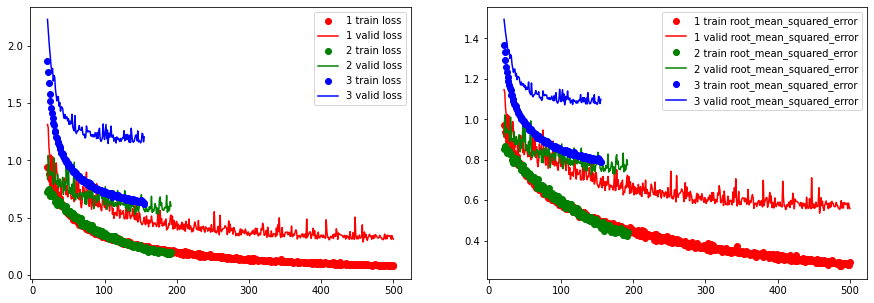

In [4]:
import matplotlib.pyplot as plt
colorMap = {1:'r',2:'g',3:'b'}

def plot_history(history,dayType):
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    mae = history_dict['root_mean_squared_error']
    val_mae = history_dict['val_root_mean_squared_error']
    epochs = range(1,len(loss)+1)
    
    n = 20
    end = 2000
    plt.subplot(1,2,1)
    plt.plot(epochs[n:end],loss[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train loss')
    plt.plot(epochs[n:end],val_loss[n:end],'b',c=colorMap[dayType],label=str(dayType)+' valid loss')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs[n:end],mae[n:end],'bo',c=colorMap[dayType],label=str(dayType)+' train root_mean_squared_error')
    plt.plot(epochs[n:end],val_mae[n:end],'b',c=colorMap[dayType],label=str(dayType)+ ' valid root_mean_squared_error')
    
plt.figure(figsize=(15,5))
plot_history(history_1d,1)
plot_history(history_2d,2)
plot_history(history_3d,3)
plt.legend()
plt.show()

## 模型融合  
### 构造样本

In [5]:
def gen_merge_feature(train_3d_df):
    part_d1_cols = cols[:40]+cols[-18:-1]
    part_d2_cols = cols[:40]+cols[-36:-1]
    part_d1_df = train_3d_df[part_d1_cols]
    part_d2_df = train_3d_df[part_d2_cols]
    part_d3_df = train_3d_df[cols[:-1]]
    sc_d1_feature = scale_fea(sc_1d,part_d1_df,'test')
    sc_d2_feature = scale_fea(sc_2d,part_d2_df,'test')
    sc_d3_feature = scale_fea(sc_3d,part_d3_df,'test')
    pred_1d = network_1d.predict(sc_d1_feature)
    pred_2d = network_2d.predict(sc_d2_feature)
    pred_3d = network_3d.predict(sc_d3_feature)
    merge_feature = np.hstack([pred_1d,pred_2d,pred_3d])
    return merge_feature

cols=list(train_3d_df.columns)
merge_feature = gen_merge_feature(train_3d_df)
merge_labels = train_3d_df[cols[-1]]
train_merge_x,test_merge_x,train_merge_y,test_merge_y = train_test_split(merge_feature,merge_labels,test_size = 0.1)
print(train_merge_x.shape)

(2430, 3)


### 模型训练

In [6]:
def build_merge_model():
    network = Sequential()
    network.add(Dense(1,input_shape=(3,))) #activation='relu',
#     network.add(Dense(64,activation='relu'))
#     network.add(Dense(32,activation='relu'))
#     network.add(Dense(1))
    opt = Adam(learning_rate = 0.001)
    network.compile(loss='mse',optimizer=opt,metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return network

def train_merge_model(train_x,train_y,test_x, test_y,model_path,epoch,batch,patience,train_type='train'):
    network = build_merge_model()
    valid_size = int(train_x.shape[0]/10)
    valid_x = train_x[:valid_size]
    partial_train_x = train_x[valid_size:]
    valid_y = train_y[:valid_size]
    partial_train_y = train_y[valid_size:]
    es = EarlyStopping(monitor='val_root_mean_squared_error',mode='min',verbose=1,patience=patience)
    ckpt = ModelCheckpoint(model_path,monitor='val_root_mean_squared_error',save_best_only=True,verbose=1,mode='min')
    if('train' == train_type):
        history = network.fit(partial_train_x,partial_train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es,ckpt]) #
    elif('total' == train_type):
        history = network.fit(train_x,train_y,epochs=epoch,batch_size=batch,validation_data=(valid_x,valid_y),callbacks=[es,ckpt])#,callbacks=[es]
    test_loss, test_rmse = network.evaluate(test_x, test_y)
    print('test_loss:%f,test_rmse:%f'% (test_loss,test_rmse))
    return network,history

model_merge_path = "/kaggle/working/model_merge/"
# epoch = 500
# batch = 10
# patience = 50
network_merge,history_merge = train_merge_model(train_merge_x,train_merge_y,test_merge_x,test_merge_y,model_merge_path,epoch,batch,patience)

Epoch 1/500
219/219 [==============================] - 1s 2ms/step - loss: 185.2690 - root_mean_squared_error: 13.5317 - val_loss: 40.1473 - val_root_mean_squared_error: 6.3362

Epoch 00001: val_root_mean_squared_error improved from inf to 6.33619, saving model to /kaggle/working/model_merge/
Epoch 2/500
219/219 [==============================] - 0s 2ms/step - loss: 26.4055 - root_mean_squared_error: 5.0815 - val_loss: 2.8992 - val_root_mean_squared_error: 1.7027

Epoch 00002: val_root_mean_squared_error improved from 6.33619 to 1.70269, saving model to /kaggle/working/model_merge/
Epoch 3/500
219/219 [==============================] - 0s 2ms/step - loss: 1.6474 - root_mean_squared_error: 1.2613 - val_loss: 0.1516 - val_root_mean_squared_error: 0.3894

Epoch 00003: val_root_mean_squared_error improved from 1.70269 to 0.38937, saving model to /kaggle/working/model_merge/
Epoch 4/500
219/219 [==============================] - 0s 2ms/step - loss: 0.1093 - root_mean_squared_error: 0.3300 -

### 效果检查

0.2126188305155548 0.0809827293859108
[array([[ 0.7563668 ],
       [ 0.26554605],
       [-0.02224457]], dtype=float32), array([-0.07424281], dtype=float32)]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


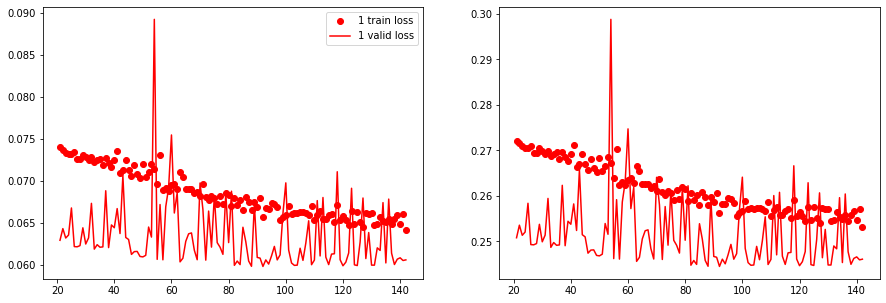

In [7]:
pred_merge = network_merge.predict(test_merge_x)
diff = pred_merge.reshape(1,-1)[0] - test_merge_y.values
weights = network_merge.get_weights()
print(np.mean(abs(diff)),np.var(diff))
print(weights)
plt.figure(figsize=(15,5))
plot_history(history_merge,1)

In [8]:
test_orig_file = "../input/ml2021spring-hw1/covid.test.csv"
res_file = "/kaggle/working/submit.csv"
test_feature = gen_merge_feature(test_3d_df)
pred = network_merge.predict(test_feature)
test_orig_df = pd.read_csv(test_orig_file)
ids = test_orig_df.id.values
with open(res_file,'w') as f_out:
    f_out.write("id,tested_positive\n")
    for i in range(len(ids)):
        outline = str(ids[i])+","+str(pred[i][0])+"\n"
        f_out.write(outline)
print("end")

end
